In [1]:
import torch

from test_importance2 import build_dataloader_and_model, inference

In [13]:
def get_importances(dataset_name: str, model_name: str):
    device = torch.device("cuda")

    dataloader, model = build_dataloader_and_model(
        dataset_name=dataset_name,
        batch_size=64,
        num_workers=4,
        model_name=model_name,
        dataset_root="../data"
    )
    model.eval()
    model.to(device)
    model.register_importance_hooks()

    labels_list = inference(dataloader, model, device)
    labels = torch.cat(labels_list, dim=0)

    importances = model.get_importances()
    importances = [
        torch.cat(scores, dim=0)
        for scores in importances
    ]

    scores_per_class = []
    for c in range(10):
        mask = labels == c
        scores_per_class.append([scores[mask].mean(0) for scores in importances])

    results = []
    for layer_idx in range(len(importances)):
        scores = torch.stack([
            scores_per_class[c][layer_idx]
            for c in range(10)
        ], dim=0)
        scores = scores.max(0)[0]
        results.append(scores)
    return results

In [14]:
cifar10_vgg16_importances = get_importances("cifar10", "vgg16")

Files already downloaded and verified


In [17]:
cifar100_vgg16_importances = get_importances("cifar100", "vgg16")

Files already downloaded and verified


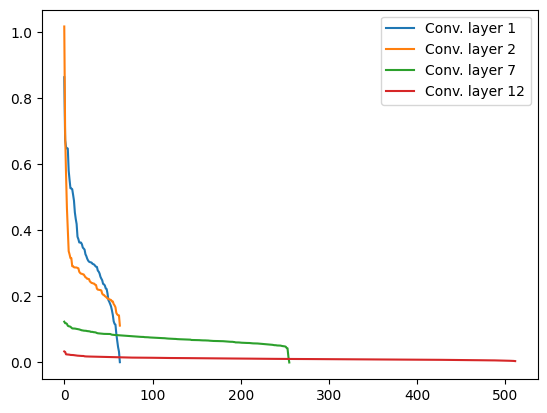

In [23]:
from matplotlib import pyplot as plt


def draw_importances(importances):
    for layer_idx in [1, 2, 7, 12]:
        layer_scores = importances[layer_idx - 1]
        layer_scores = layer_scores.cpu().sort(descending=True)[0].numpy()
        plt.plot(range(layer_scores.shape[0]), layer_scores, label=f"Conv. layer {layer_idx}")
    plt.legend(loc="upper right")
    plt.show()


draw_importances(cifar10_vgg16_importances)

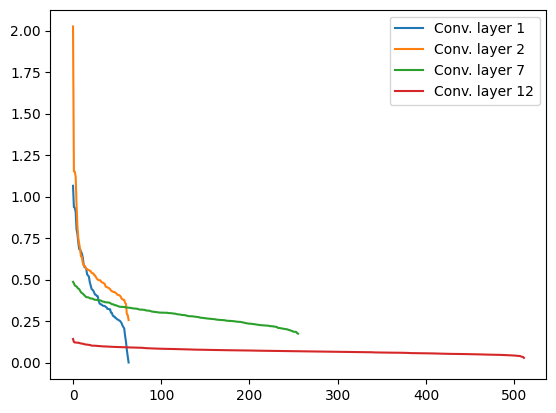

In [24]:
draw_importances(cifar100_vgg16_importances)

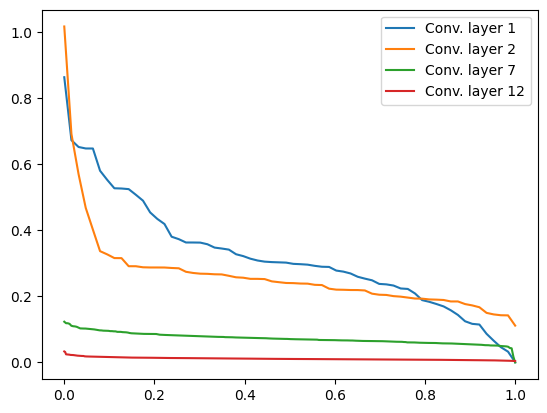

In [25]:
import numpy as np


def draw_importances_norm(importances):
    for layer_idx in [1, 2, 7, 12]:
        layer_scores = importances[layer_idx - 1]
        layer_scores = layer_scores.cpu().sort(descending=True)[0].numpy()

        plt.plot(
            np.linspace(0, 1, num=layer_scores.shape[0]), layer_scores,
            label=f"Conv. layer {layer_idx}",
        )
    plt.legend(loc="upper right")
    plt.show()


draw_importances_norm(cifar10_vgg16_importances)

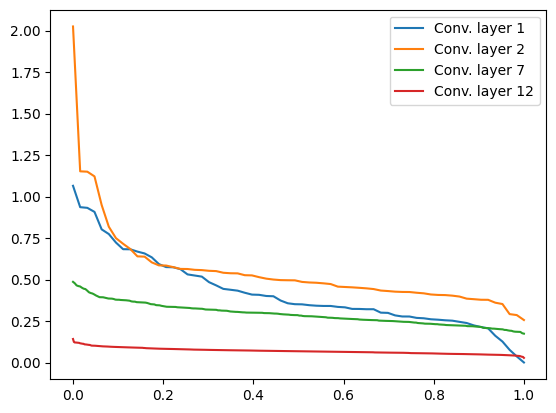

In [26]:
draw_importances_norm(cifar100_vgg16_importances)